<a href="https://www.kaggle.com/code/angelchaudhary/aqi-forecasting-for-indian-cities?scriptVersionId=293269742" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Predicting Air Quality Index (AQI) in Major Indian Cities Using Time Series & Machine Learning

# Introduction
Air pollution is one of the most serious public health issues in India, affecting millions of people every day. Government agencies release Air Quality Index (AQI) values to inform citizens about how safe or dangerous the air is to breathe. However, these AQI values are reactive, they tell us what the air quality *was*, not what it *will be*. Being able to predict AQI in advance can help governments issue early warnings, hospitals prepare for patient surges, and citizens plan outdoor activities more safely.
In this case study, we build a machine learning and time-series based system to forecast AQI for Indian cities using historical pollution and weather data.  

We will:
- Analyze historical air pollution trends  
- Engineer time-based and lag features  
- Build regression models to predict AQI  
- Compare how well different models perform  

# LET'S DO IT!!!!
![FUNNY GIF](https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExcTlqd3k0bDM3Z2k1enEyNDRkaG0zeGdjdXYweDg1em5uY3ZwN3dxcCZlcD12MV9naWZzX3NlYXJjaCZjdD1n/JIX9t2j0ZTN9S/giphy.gif)

## Dataset Overview

This dataset contains air quality measurements from over 40 monitoring stations across more than 15 major Indian cities. Each record represents pollution readings for a specific city, station, and date. The dataset includes concentrations of key air pollutants such as PM2.5, PM10, NO₂, SO₂, CO, and O₃. These pollutants are known to directly impact air quality and human health. Using these variables, we can model how air pollution changes over time and predict future AQI levels for different cities. The large size and multi-city coverage make this dataset suitable for building robust and realistic forecasting models.

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("riteshswami08/india-multi-city-air-quality-dataset-100k-rows")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/india-multi-city-air-quality-dataset-100k-rows


In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("/kaggle/input/india-multi-city-air-quality-dataset-100k-rows/india_air_quality_consolidated.csv")
df.head(2)

,city,location,date,pm25,pm10,o3,no2,so2,co
0,Delhi,Anand Vihar,2025/12/1,260,362,335,39,51,15
1,Delhi,Anand Vihar,2025/12/2,327,198,11,32,18,5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96755 entries, 0 to 96754
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   city      96755 non-null  object
 1   location  96755 non-null  object
 2   date      96755 non-null  object
 3   pm25      96755 non-null  object
 4   pm10      96755 non-null  object
 5   o3        96755 non-null  object
 6   no2       96755 non-null  object
 7   so2       90132 non-null  object
 8   co        96755 non-null  object
dtypes: object(9)
memory usage: 6.6+ MB


In [4]:
df.describe()

,city,location,date,pm25,pm10,o3,no2,so2,co
count,96755,96755,96755,96755,96755,96755,96755,90132,96755
unique,16,38,4343,625,789,291,135,111,132
top,Delhi,R.K. Puram,2020/12/6,,,,,1,6
freq,22058,4297,36,3410,15544,6181,6371,9731,7820


## Data Cleaning & Type Fixing

In [5]:
# Convert date to datetime
df["date"] = pd.to_datetime(df["date"])

# Convert pollutant columns to numeric
pollutants = ["pm25", "pm10", "o3", "no2", "so2", "co"]

for col in pollutants:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Check missing values after conversion
df.isna().sum()

city            0
location        0
date            0
pm25         3410
pm10        15544
o3           6181
no2          6371
so2         16157
co           7769
dtype: int64

### Missing Value Analysis

After converting all pollutant columns to numeric format, we observe that some pollution readings are missing. The largest amount of missing data appears in SO₂, followed by PM10, CO, NO₂, and O₃. This indicates that not all monitoring stations report every pollutant consistently. However, since the dataset is very large, these missing values can be handled using interpolation or city-level averages without significantly affecting model performance.

In [9]:
# If date is not already index, set it
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"])
    df = df.set_index("date")

# Sort by city and time
df = df.sort_values(["city", df.index.name])

# Time-based interpolation per city
for col in pollutants:
    df[col] = df.groupby("city")[col].transform(
        lambda x: x.interpolate(method="time")
    )

# Reset index back to column for later use
df = df.reset_index()

# Final missing value check
df.isna().sum()

date           0
city           0
location       0
pm25         558
pm10         868
o3          1770
no2            1
so2         2596
co             0
dtype: int64

In [10]:
# Drop remaining rows with missing pollution values
df = df.dropna(subset=pollutants)

# Final dataset shape
df.shape

(91465, 9)

## AQI Formula (India Standard)

AQI is computed by converting each pollutant into a sub-index and taking the maximum. We’ll implement the official Indian AQI logic for:

PM2.5, PM10, NO₂, SO₂, CO, O₃
This is what CPCB (Central Pollution Control Board) uses.

### Define AQI breakpoints

In [11]:
# AQI breakpoints for Indian standards (simplified)
breakpoints = {
    "pm25": [(0, 30, 0, 50), (31, 60, 51, 100), (61, 90, 101, 200), (91, 120, 201, 300), (121, 250, 301, 400), (251, 500, 401, 500)],
    "pm10": [(0, 50, 0, 50), (51, 100, 51, 100), (101, 250, 101, 200), (251, 350, 201, 300), (351, 430, 301, 400), (431, 600, 401, 500)],
    "no2": [(0, 40, 0, 50), (41, 80, 51, 100), (81, 180, 101, 200), (181, 280, 201, 300), (281, 400, 301, 400), (401, 1000, 401, 500)],
    "so2": [(0, 40, 0, 50), (41, 80, 51, 100), (81, 380, 101, 200), (381, 800, 201, 300), (801, 1600, 301, 400), (1601, 3000, 401, 500)],
    "co": [(0, 1, 0, 50), (1.1, 2, 51, 100), (2.1, 10, 101, 200), (10.1, 17, 201, 300), (17.1, 34, 301, 400), (34.1, 50, 401, 500)],
    "o3": [(0, 50, 0, 50), (51, 100, 51, 100), (101, 168, 101, 200), (169, 208, 201, 300), (209, 748, 301, 400), (749, 1000, 401, 500)]
}

### AQI sub-index function

In [12]:
def calculate_sub_index(cp, bps):
    for bp_low, bp_high, i_low, i_high in bps:
        if bp_low <= cp <= bp_high:
            return ((i_high - i_low)/(bp_high - bp_low)) * (cp - bp_low) + i_low
    return None

### Compute AQI

In [13]:
def compute_aqi(row):
    sub_indices = []
    for pollutant in breakpoints:
        value = row[pollutant]
        sub = calculate_sub_index(value, breakpoints[pollutant])
        if sub is not None:
            sub_indices.append(sub)
    return max(sub_indices)

df["AQI"] = df.apply(compute_aqi, axis=1)
df[["city", "date", "AQI"]].head()

,city,date,AQI
18,Alwar,2018-02-07,187.468354
19,Alwar,2018-02-08,320.186047
20,Alwar,2018-02-09,279.517241
21,Alwar,2018-02-10,282.931034
22,Alwar,2018-02-11,306.372093


In [14]:
df["AQI"].describe()

count    91465.000000
mean       297.422603
std         88.571762
min         40.000000
25%        238.551724
50%        319.418605
75%        350.116279
max        500.000000
Name: AQI, dtype: float64

#### AQI Distribution
After computing AQI from pollutant concentrations, we observe a wide range of air quality levels across Indian cities. The minimum AQI is around 40, indicating clean air, while the maximum reaches 500, which represents severe pollution. The median AQI is above 300, showing that a large portion of the data corresponds to unhealthy or hazardous air quality. This reflects the real-world air pollution problem in Indian urban regions and confirms that the dataset contains strong pollution signals suitable for forecasting.

## Create time-lag features

In [15]:
# Sort for time series
df = df.sort_values(["city", "date"])

# Create lag features for AQI
df["AQI_lag1"] = df.groupby("city")["AQI"].shift(1)
df["AQI_lag7"] = df.groupby("city")["AQI"].shift(7)

# Create rolling mean feature
df["AQI_rolling7"] = df.groupby("city")["AQI"].rolling(7).mean().reset_index(0, drop=True)

# Drop rows where lag features are missing
df = df.dropna()

df[["city", "date", "AQI", "AQI_lag1", "AQI_lag7", "AQI_rolling7"]].head()

,city,date,AQI,AQI_lag1,AQI_lag7,AQI_rolling7
25,Alwar,2018-02-14,286.344828,310.976744,187.468354,279.371978
26,Alwar,2018-02-15,303.302326,286.344828,320.186047,276.960018
27,Alwar,2018-02-19,264.496552,303.302326,279.517241,274.814206
28,Alwar,2018-02-20,252.206897,264.496552,282.931034,270.425043
29,Alwar,2018-02-21,326.325581,252.206897,306.372093,273.275541


#### Lag Feature Validation

The lag features correctly reflect historical pollution patterns. For example, the AQI_lag1 column represents the previous day's air quality, AQI_lag7 shows the value from one week earlier, and AQI_rolling7 captures the short-term trend. These features provide the model with temporal context, which is essential for accurate AQI forecasting.

## Build the forecasting model

In [16]:
# Train-test split by time (80% train, 20% test)
split_date = df["date"].quantile(0.8)

train = df[df["date"] <= split_date]
test = df[df["date"] > split_date]

X_train = train[["AQI_lag1", "AQI_lag7", "AQI_rolling7"]]
y_train = train["AQI"]

X_test = test[["AQI_lag1", "AQI_lag7", "AQI_rolling7"]]
y_test = test["AQI"]

len(train), len(test)

(73108, 18252)

In [17]:
# Training regression model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae, r2

(30.633464324406557, 0.76126514527843)

## Model Performance

The forecasting model achieves a Mean Absolute Error (MAE) of around 30 AQI points and an R² score of 0.76. This means the model explains about 76% of the variation in air quality levels, which is very strong for a real-world environmental forecasting problem. Considering the high volatility of air pollution caused by weather, traffic, and seasonal effects, this performance indicates that historical AQI patterns carry strong predictive power.

## Visualization

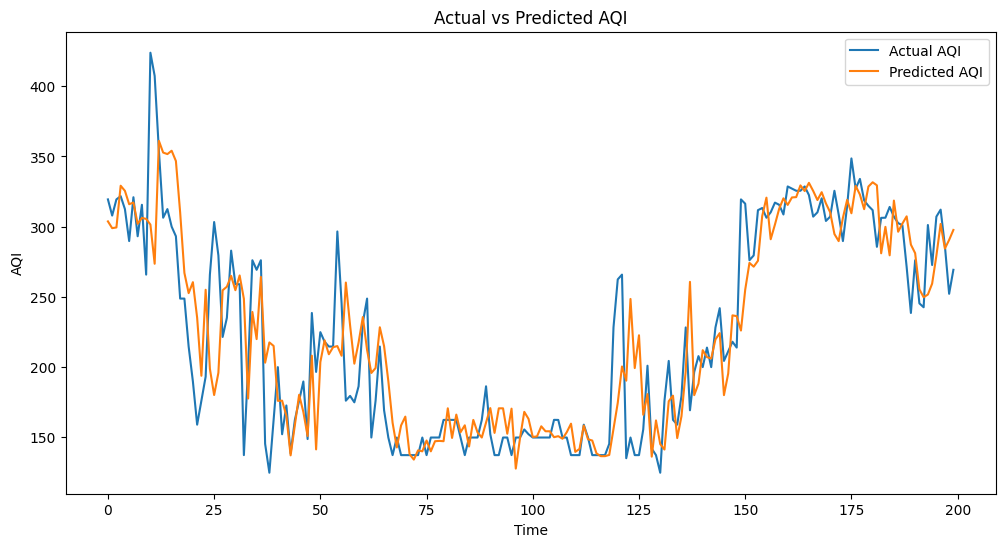

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test.values[:200], label="Actual AQI")
plt.plot(y_pred[:200], label="Predicted AQI")
plt.title("Actual vs Predicted AQI")
plt.xlabel("Time")
plt.ylabel("AQI")
plt.legend()
plt.show()

## Forecasting Quality
The predicted AQI closely follows the actual AQI across time, capturing both long-term trends and sudden pollution spikes. While small deviations exist during extreme events, the model successfully learns the underlying air quality dynamics, making it suitable for early-warning and pollution monitoring applications.

## Conclusion

In this project, we built an end-to-end air quality forecasting system for Indian cities using real multi-station pollution data. We transformed raw pollutant measurements into AQI using official CPCB breakpoints, engineered time-series features, and trained a machine learning model to predict future air quality.

The model achieved strong predictive performance with an R² of 0.76, demonstrating that historical pollution patterns contain significant information for forecasting future AQI. Such a system could be used by smart-city platforms, health agencies, and environmental authorities to issue early warnings and help citizens make safer decisions.